In [39]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# Data observation

## Transactions data

In [40]:
transactions_data = pd.read_csv('transactions.csv')

In [41]:
transactions_data.tail()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
6849341,61870738,453 16:03:02,5499,1010,-5176.84,10217113
6849342,61870738,454 10:54:60,5411,1010,-1652.77,022915
6849343,61870738,454 14:23:59,5499,1010,-4687.23,10217113
6849344,61870738,454 16:11:53,5541,1110,-4491.83,RU570124
6849345,61870738,454 18:06:30,6011,7010,408756.67,372701


In [42]:
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849346 entries, 0 to 6849345
Data columns (total 6 columns):
customer_id    int64
tr_datetime    object
mcc_code       int64
tr_type        int64
amount         float64
term_id        object
dtypes: float64(1), int64(3), object(2)
memory usage: 313.5+ MB


In [43]:
customers = np.unique(transactions_data['customer_id'])

## MCC_Codes data

In [44]:
tr_mcc_codes = pd.read_csv('tr_mcc_codes.csv', sep=';')

In [45]:
tr_mcc_codes.head()

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


In [46]:
tr_mcc_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
mcc_code           184 non-null int64
mcc_description    184 non-null object
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


## Transactions type data

In [47]:
tr_types = pd.read_csv('tr_types.csv', sep=';')

In [48]:
tr_types.head()

,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [49]:
tr_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 2 columns):
tr_type           155 non-null int64
tr_description    155 non-null object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


## Date transformation

We have to choose step for our time series.
Let's divide our data by days

In [50]:
transactions_data['day'] = pd.to_numeric(list(map(lambda x: x.split()[0], transactions_data['tr_datetime'])))

In [51]:
transactions_data.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2


Let's divide our data by clients

In [52]:
def get_customers_dict(transactions_data):
    customers_data = {}
    customers_id = np.unique(transactions_data['customer_id'])
    for customer in customers_id:
        customers_data[customer] = transactions_data[transactions_data['customer_id'] == customer]
    return customers_id, customers_data

In [53]:
customers_id, customers_data = get_customers_dict(transactions_data)

Let's find out an average number of transaction for each client per day

In [54]:
transaction_amount = []
for customer in customers_id:
    transaction_amount.append(len(customers_data[customer])/len(np.unique(customers_data[customer]['day'])))

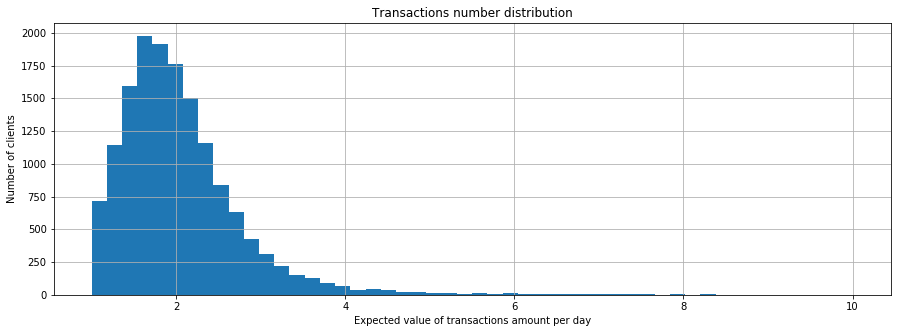

In [55]:
fig = plt.figure(figsize=(15,5))
plt.hist(transaction_amount, 50,  range=(1,10))
plt.title('Transactions number distribution')
plt.xlabel('Expected value of transactions amount per day')
plt.ylabel('Number of clients')
plt.grid(True)
plt.show()

As you can see the average amount of transactions is nearly two per day.
So we can get rid of time in our task.

In [56]:
for customer in customers_id:
    customers_data[customer] = customers_data[customer].drop('tr_datetime', axis=1)

## Info

In [57]:
print("There are %s customers." % len(customers))
print("There are %s transaction types." % len(tr_types))
print("There are %s MCC codes." % len(tr_mcc_codes))
print("The possible period of transactions observation is %s." % transactions_data['day'].max())

There are 15000 customers.
There are 155 transaction types.
There are 184 MCC codes.
The possible period of transactions observation is 456.


## Clients datasets

Let's check out the client's full number of transactions disturbtion

In [58]:
q = []
for customer in customers_id:
    q.append(len(customers_data[customer]))

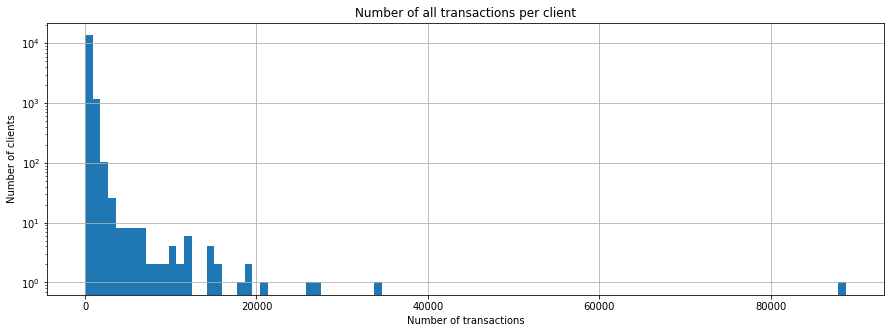

In [59]:
fig = plt.figure(figsize=(15,5))
plt.hist(x=q, bins=100, log=True)
plt.title('Number of all transactions per client')
plt.xlabel('Number of transactions')
plt.ylabel('Number of clients')
plt.grid(True)
plt.show()

## Time series creation

For our purporses we need dataset which has data for every time period(in our case is day).
Let's calculate the average amount of transactions per day for each client and select ten clients with the highest number of transactions.

In [61]:
amount_per_day_data = {}
for customer in customers_id:
    days = np.unique(customers_data[customer]['day'])
    value = list(map(lambda day: sum(customers_data[customer][customers_data[customer]['day'] == day]['amount']) / len(customers_data[customer][customers_data[customer]['day'] == day]), days))
    amount_per_day_data[customer] = pd.DataFrame(data = {'day': days, 'value' : value}) 

Select clients with highest number of entries.

In [74]:
days_number = transactions_data['day'].max()
for i in range(0,10):
    print("There are {} clients with data  for {} days.".format(sum(map(lambda customer: len(amount_per_day_data[customer]) == days_number - i, customers_id)), days_number - i))

There are 1 clients with data  for 456 days.
There are 3 clients with data  for 455 days.
There are 0 clients with data  for 454 days.
There are 1 clients with data  for 453 days.
There are 4 clients with data  for 452 days.
There are 3 clients with data  for 451 days.
There are 6 clients with data  for 450 days.
There are 5 clients with data  for 449 days.
There are 1 clients with data  for 448 days.
There are 1 clients with data  for 447 days.


In [75]:
i = 0
for customer in customers_id:
    if(len(amount_per_day_data[customer]) > 450):
        amount_per_day_data[customer].to_csv('transactions_data/client' + str(i) + '.csv')
        i = i + 1